# Importing

In [4]:
#importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings("ignore")

In [5]:
#importing data
df=pd.read_csv('stroke_data.csv')

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.shape

(5110, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 4 categorical columns and there are missing values.

# Handling missing values

In [9]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

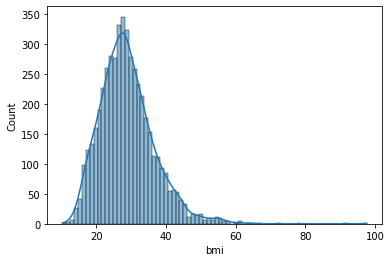

In [10]:
sns.histplot(df['bmi'].dropna(), kde=True)
plt.show()

Data is right skewed.It is better to use median to fill the missing values than the mean because it is less affected by outliers and preserves the skewness of the distribution.

In [11]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [12]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
df.duplicated().sum()

0

# Exploratory Data Analysis

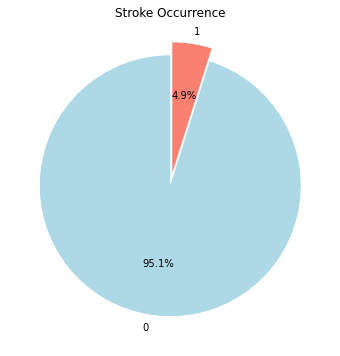

In [14]:
#Stroke Occurence Chance
stroke_counts = df['stroke'].value_counts()
explode = [0, 0.1] 
plt.figure(figsize=(6, 6))
plt.pie(stroke_counts, labels=stroke_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'],explode=explode)
plt.title("Stroke Occurrence")
plt.show()

Strokes were reported in just 5% of the data.

In [15]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Since 'Other' is only present in one row, it would be best to remove that row.

In [16]:
df.drop(df[df['gender']=='Other'].index,inplace=True)

In [14]:
df.shape

(5109, 12)

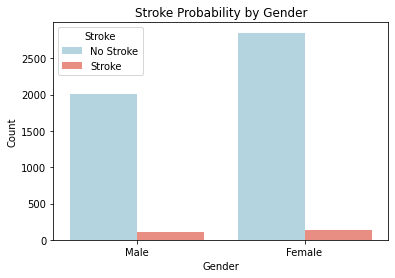

In [17]:
#Gender vs Stroke
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='stroke', data=df, palette=['lightblue', 'salmon'])
plt.title("Stroke Probability by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Stroke", labels=["No Stroke", "Stroke"])
plt.show()

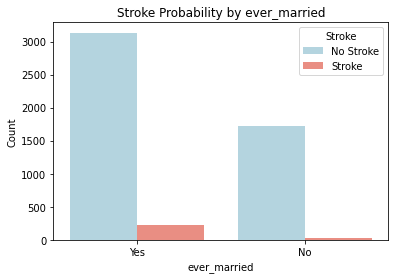

In [16]:
#Ever_married vs Stroke
plt.figure(figsize=(6, 4))
sns.countplot(x='ever_married', hue='stroke', data=df, palette=['lightblue', 'salmon'])
plt.title("Stroke Probability by ever_married")
plt.xlabel("ever_married")
plt.ylabel("Count")
plt.legend(title="Stroke", labels=["No Stroke", "Stroke"])
plt.show()

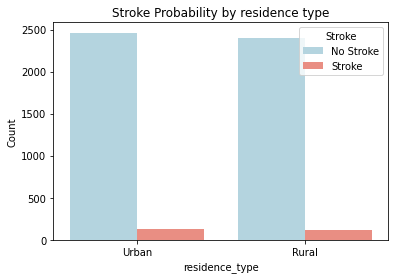

In [18]:
#Residence_type vs Stroke
plt.figure(figsize=(6, 4))
sns.countplot(x='residence_type', hue='stroke', data=df, palette=['lightblue', 'salmon'])
plt.title("Stroke Probability by residence type")
plt.xlabel("residence_type")
plt.ylabel("Count")
plt.legend(title="Stroke", labels=["No Stroke", "Stroke"])
plt.show()

The difference in stroke risk between rural and urban areas is minimal.

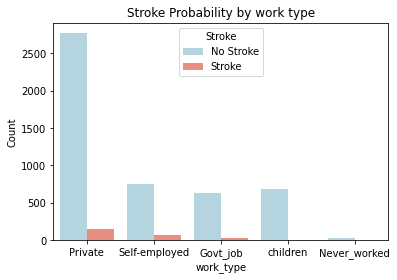

In [19]:
#Work type vs Stroke
plt.figure(figsize=(6, 4))
sns.countplot(x='work_type', hue='stroke', data=df, palette=['lightblue', 'salmon'])
plt.title("Stroke Probability by work type")
plt.xlabel("work_type")
plt.ylabel("Count")
plt.legend(title="Stroke", labels=["No Stroke", "Stroke"])
plt.show()

Unable to determine which individuals with a certain work type are more likely to suffer strokes due to the uneven distribution of categories. Plotting probabilities is therefore preferable.

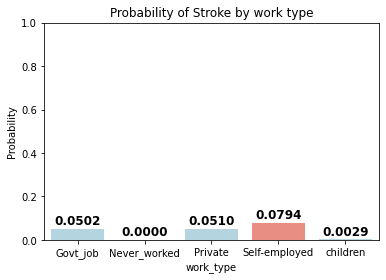

In [20]:
# Stroke probabilities per work_type
work_type_counts = df['work_type'].value_counts()
stroke_counts = df[df['stroke'] == 1]['work_type'].value_counts()
probabilities = (stroke_counts / work_type_counts).fillna(0)  # Fill NaN with 0 if no strokes in a category

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=probabilities.index, y=probabilities.values, palette=['lightblue', 'salmon'])

# Add probability values on top of bars
for i, p in enumerate(probabilities.values):
    ax.text(i, p + 0.02, f'{p:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.title("Probability of Stroke by work type")
plt.xlabel("work_type")
plt.ylabel("Probability")
plt.ylim(0, 1) 
plt.show()

Comparitively employed people have higher risk of stroke

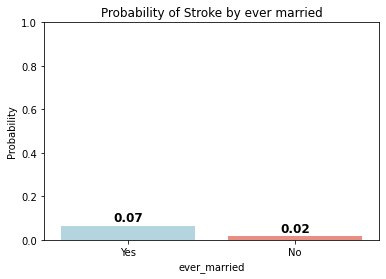

In [21]:
# Stroke probabilities per ever_married
ever_married_counts = df['ever_married'].value_counts()
stroke_counts = df[df['stroke'] == 1]['ever_married'].value_counts()
probabilities = (stroke_counts / ever_married_counts).fillna(0)  # Fill NaN with 0 if no strokes in a category

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=probabilities.index, y=probabilities.values, palette=['lightblue', 'salmon'])

# Add probability values on top of bars
for i, p in enumerate(probabilities.values):
    ax.text(i, p + 0.02, f'{p:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.title("Probability of Stroke by ever married")
plt.xlabel("ever_married")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()

The risk of stroke is slightly higher for married people.

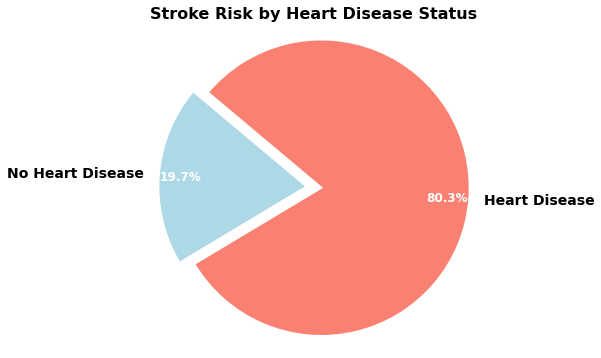

In [22]:
df_grouped = df.groupby(['heart_disease', 'stroke']).size().unstack(fill_value=0)
df_grouped_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
# Data
labels = ['No Heart Disease', 'Heart Disease']
sizes = df_grouped_percent[1]
colors = ['lightblue', 'salmon']  
explode = [0, 0.1]  

# Creating pie chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, 
    pctdistance=0.85, wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Adjusting text styles for clarity
plt.setp(autotexts, size=12, weight="bold", color='white')
plt.setp(texts, size=14, weight="bold", color='black')

# Title
ax.set_title('Stroke Risk by Heart Disease Status', fontsize=16, weight='bold')
ax.axis('equal')
plt.show()

Individuals with heart disease have a 60% higher risk of having a stroke.

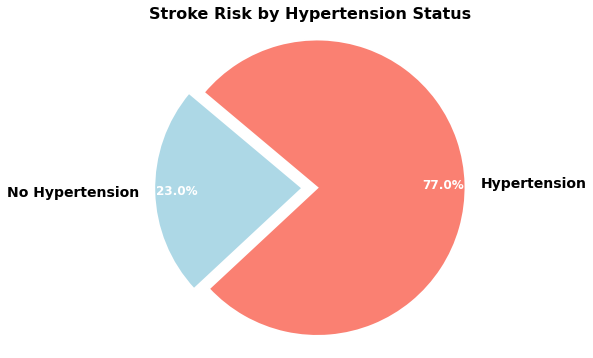

In [23]:
df_grouped = df.groupby(['hypertension', 'stroke']).size().unstack(fill_value=0)
df_grouped_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
# Data
labels = ['No Hypertension', 'Hypertension']
sizes = df_grouped_percent[1]
colors = ['lightblue', 'salmon']  
explode = [0, 0.1]  

# Creating pie chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, 
    pctdistance=0.85, wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Adjusting text styles for clarity
plt.setp(autotexts, size=12, weight="bold", color='white')
plt.setp(texts, size=14, weight="bold", color='black')

# Title
ax.set_title('Stroke Risk by Hypertension Status', fontsize=16, weight='bold')
ax.axis('equal')
plt.show()

Individuals with Hypertension have a 54% higher risk of having a stroke

In [24]:
df.age.sort_values()

1614     0.08
3295     0.08
3968     0.16
3618     0.16
4021     0.16
        ...  
2876    82.00
35      82.00
3603    82.00
4088    82.00
4819    82.00
Name: age, Length: 5109, dtype: float64

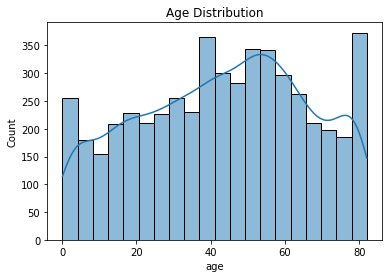

In [25]:
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

looks like there are decimal values in age that too less than 1 year they might be outliers

In [26]:
df.sort_values(by='age')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2876,11327,Female,82.00,0,0,Yes,Self-employed,Urban,79.96,27.0,formerly smoked,0
35,712,Female,82.00,1,1,No,Private,Rural,84.03,26.5,formerly smoked,1
3603,28247,Male,82.00,0,0,No,Self-employed,Urban,101.57,24.3,smokes,0
4088,27705,Female,82.00,0,1,Yes,Self-employed,Rural,88.60,32.5,Unknown,0


All these people are children, so they are not outliers; no need to drop them. Better to round up the decimal values of ages.

In [27]:
df['age']=np.ceil(df['age'])

<Axes: xlabel='age', ylabel='Density'>

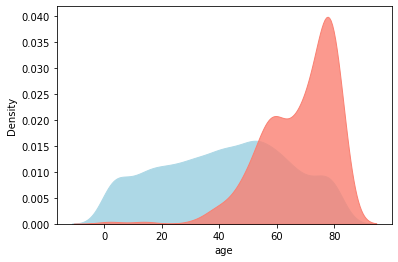

In [28]:
sns.kdeplot(data=df[df['stroke'] == 0], x='age', shade=True, alpha=1, color='lightblue')
sns.kdeplot(data=df[df['stroke'] == 1], x='age', shade=True, alpha=0.8, color='salmon')

Significantly more strokes are occurring in older adults.

In [29]:
#Smoking status vs Stroke
df_grouped = df.groupby(['smoking_status', 'stroke']).size().unstack(fill_value=0)
df_grouped_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100


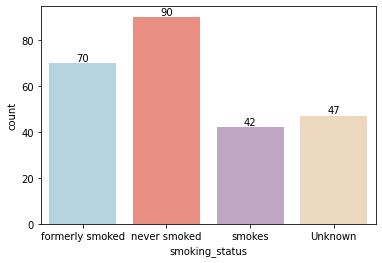

In [30]:
ax=sns.countplot(x='smoking_status',data=df[df['stroke']==1],palette=['lightblue', 'salmon','#C3A2C8', '#F4D7B7'])
ax.bar_label(ax.containers[0])  
plt.show()

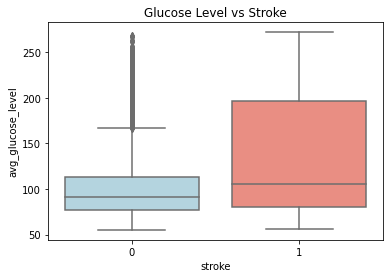

In [31]:
#avg_glucose_level vs stroke
sns.boxplot(x='stroke', y='avg_glucose_level', data=df,palette=['lightblue', 'salmon'])
plt.title("Glucose Level vs Stroke")
plt.show()

High avg_glucose_level individuals are more likely to suffer a stroke

# Feature transformation

In [32]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [33]:

# Convert binary categorical to numerical
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
df['residence_type'] = df['residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)


In [34]:
# Define X and y
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']


In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [36]:

numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'work_type', 'smoking_status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)


# Resampling using SMOTE

The data is highly biased towards a single class(no stroke).Hence we must handle class imbalance before training algorithms.For that we can use Synthetic Minority Oversampling Technique.

In [37]:
# Build pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])


## Fitting Models

We will fit three different models for stroke prediction:
- **Logistic Regression**
- **Support Vector Machine (SVM)**
- **Random Forest**

These models will be trained and evaluated on the resampled data using different performance metrics like accuracy, recall, precision, F1 score, and AUC-ROC score.

In [ ]:
#Logistic Regression

In [38]:
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("🔹 Logistic Regression")
print(f"Training score: {lr_pipeline.score(X_train, y_train)}")
print(f"Testing score: {lr_pipeline.score(X_test, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_lr)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Precision: {precision_score(y_test, y_pred_lr)}")
print(f"Recall: {recall_score(y_test, y_pred_lr)}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr)}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_lr)}\n")


🔹 Logistic Regression
Training score: 0.756152125279642
Testing score: 0.7423352902804957
Confusion Matrix:
[[1074  370]
 [  25   64]]
Accuracy: 0.7423352902804957
Precision: 0.14746543778801843
Recall: 0.7191011235955056
F1 Score: 0.2447418738049713
AUC-ROC Score: 0.731434218307448



In [ ]:
# Support Vector Machine

In [39]:
svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("🔹 Support Vector Machine")
print(f"Training score: {svm_pipeline.score(X_train, y_train)}")
print(f"Testing score: {svm_pipeline.score(X_test, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svm)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall: {recall_score(y_test, y_pred_svm)}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm)}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_svm)}\n")


🔹 Support Vector Machine
Training score: 0.8657718120805369
Testing score: 0.8343118069145466
Confusion Matrix:
[[1238  206]
 [  48   41]]
Accuracy: 0.8343118069145466
Precision: 0.1659919028340081
Recall: 0.4606741573033708
F1 Score: 0.24404761904761904
AUC-ROC Score: 0.6590074387624888



In [ ]:
# Random Forest

In [40]:
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("🔹 Random Forest Classifier")
print(f"Training score: {rf_pipeline.score(X_train, y_train)}")
print(f"Testing score: {rf_pipeline.score(X_test, y_test)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_rf)}\n")


🔹 Random Forest Classifier
Training score: 1.0
Testing score: 0.9302022178734507
Confusion Matrix:
[[1419   25]
 [  82    7]]
Accuracy: 0.9302022178734507
Precision: 0.21875
Recall: 0.07865168539325842
F1 Score: 0.11570247933884299
AUC-ROC Score: 0.5306693330013383



Recall is more important in our case.but rf completely failed on detecting strokes.the accuracy is higher since the data for not having stroke is higher and which is correctly classified.Between SVM and Logistic Regression,Logistic Regression has better recall and auc-roc score.

##  Predicting from Single Input

In [41]:

single_input = {
    'gender': 'Male',
    'age': 33,
    'hypertension': 0,
    'heart_disease': 0,
    'ever_married': 'Yes',
    'work_type': 'Private',
    'residence_type': 'Urban',
    'avg_glucose_level': 79.53,
    'bmi': 31.10,
    'smoking_status': 'formerly smoked'
}

In [42]:

# Convert single input to DataFrame
single_df = pd.DataFrame([single_input])


In [43]:
# Apply same transformations to binary variables
single_df['ever_married'] = single_df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
single_df['residence_type'] = single_df['residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)


In [44]:
# Predict
single_prediction = lr_pipeline.predict(single_df)[0]
print(f"Prediction for single input (1=stroke, 0=no stroke): {single_prediction}")


Prediction for single input (1=stroke, 0=no stroke): 0


## Saving the model

In [45]:
import joblib

joblib.dump(lr_pipeline, 'stroke_model.pkl')


['stroke_model.pkl']